In [2]:
!pip install ../facenet-pytorch/facenet_pytorch-2.0.0-py3-none-any.whl --user

Processing /home/ec2-user/SageMaker/facenet-pytorch/facenet_pytorch-2.0.0-py3-none-any.whl


In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import torch
from tqdm.notebook import tqdm
import time

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [248]:
#os.listdir('../data/deepfake-samples/sample/train_sample_videos/')

In [90]:
sample = '../data/deepfake-samples/sample/train_sample_videos/acxwigylke.mp4'

reader = cv2.VideoCapture(sample)
images_1080_1920 = []
images_720_1280 = []
images_540_960 = []
for i in tqdm(range(int(reader.get(cv2.CAP_PROP_FRAME_COUNT)))):
    _, image = reader.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_1080_1920.append(cv2.resize(image, (1080, 1920)))
    images_720_1280.append(cv2.resize(image, (1280, 720)))
    images_540_960.append(cv2.resize(image, (960, 540)))
reader.release()

images_1080_1920 = np.stack(images_1080_1920)
images_720_1280 = np.stack(images_720_1280)
images_540_960 = np.stack(images_540_960)

print('Shapes:')
print(images_1080_1920.shape)
print(images_720_1280.shape)
print(images_540_960.shape)


Shapes:
(298, 1920, 1080, 3)
(298, 720, 1280, 3)
(298, 540, 960, 3)


In [290]:
def plot_faces(images, figsize=(10.8/2, 19.2/2)):
    shape = images[0].shape
    images = images[np.linspace(0, len(images)-1, 16).astype(int)]
    im_plot = []
    for i in range(0, 16, 4):
        im_plot.append(np.concatenate(images[i:i+4], axis=0))
    im_plot = np.concatenate(im_plot, axis=1)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(im_plot)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    ax.grid(False)
    fig.tight_layout()

def timer(detector, detect_fn, images, *args):
    start = time.time()
    faces, faces_dict = detect_fn(detector, images, *args)
    elapsed = time.time() - start
    print(f', {elapsed:.3f} seconds')
    return faces, elapsed, faces_dict

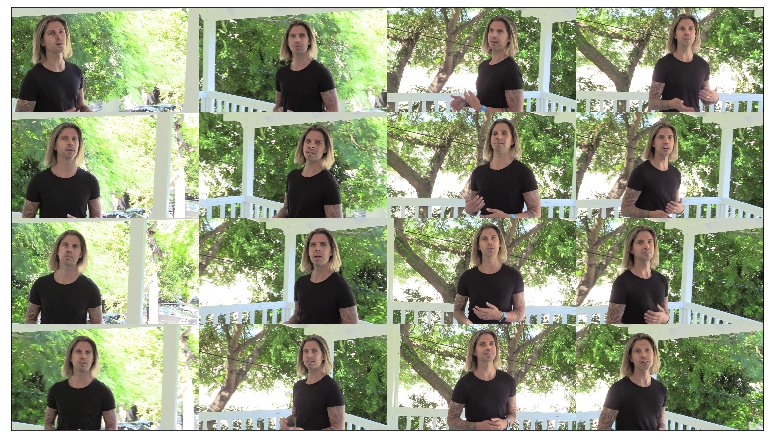

In [6]:
plot_faces(images_540_960, figsize=(10.8, 19.2))

In [7]:
device

'cuda:0'

In [107]:
'''
from facenet_pytorch import MTCNN
detector = MTCNN(image_size=224, device=device, post_process=False)

def detect_facenet_pytorch(detector, images, batch_size):
    faces = []
    for lb in np.arange(0, len(images), batch_size):
        imgs_pil = [Image.fromarray(image) for image in images[lb:lb+batch_size]]
        faces.extend(detector(imgs_pil))
    return faces

times_facenet_pytorch = []    # batched
times_facenet_pytorch_nb = [] # non-batched
'''

Detecting faces in 540x960 frames, 7.133 seconds
Detecting faces in 720x1280 frames, 9.635 seconds
Detecting faces in 1080x1920 frames, 13.678 seconds


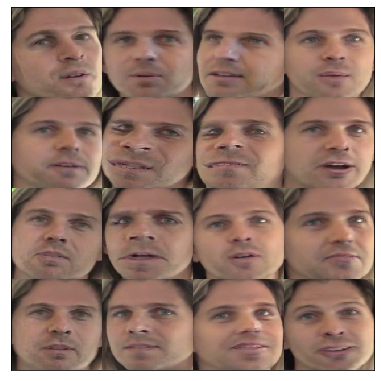

In [10]:
print('Detecting faces in 540x960 frames', end='')
_, elapsed = timer(detector, detect_facenet_pytorch, images_540_960, 60)
times_facenet_pytorch.append(elapsed)

print('Detecting faces in 720x1280 frames', end='')
_, elapsed = timer(detector, detect_facenet_pytorch, images_720_1280, 40)
times_facenet_pytorch.append(elapsed)

print('Detecting faces in 1080x1920 frames', end='')
faces, elapsed = timer(detector, detect_facenet_pytorch, images_1080_1920, 20)
times_facenet_pytorch.append(elapsed)

plot_faces(torch.stack(faces).permute(0, 2, 3, 1).int().numpy())

In [16]:
images_720_1280.shape

(300, 720, 1280, 3)

In [25]:
faces[0].shape

torch.Size([3, 160, 160])

-------------------------------------------------------------------------------------------------  

### Preprocessing Video

Working on streamlining the preprocessing. Will attempt to pull frame 100 from the entire dataset. Plan is to use cv2 to grab the frame and save the frame to a list. Then use facenet to detect face and crop on face. And then save to disk. 

In [51]:
import os
import json
import pandas as pd

In [111]:
video_dir = ('../data/deepfake-samples/sample/train_sample_videos')
f100_dir = ('../data/f100')
meta_file = os.path.join(video_dir, 'metadata.json')

os.makedirs(output_dir, exist_ok=True)

with open(meta_file) as f:
    metadata = pd.read_json(f).T

In [50]:
metadata.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [58]:
n = 0
for i in metadata.index:
    if metadata['label'][i] == 'REAL':
        n += 1

In [59]:
n

77

In [65]:
metadata.index

Index(['aagfhgtpmv.mp4', 'aapnvogymq.mp4', 'abarnvbtwb.mp4', 'abofeumbvv.mp4',
       'abqwwspghj.mp4', 'acifjvzvpm.mp4', 'acqfdwsrhi.mp4', 'acxnxvbsxk.mp4',
       'acxwigylke.mp4', 'aczrgyricp.mp4',
       ...
       'esnntzzajv.mp4', 'esxrvsgpvb.mp4', 'esyhwdfnxs.mp4', 'esyrimvzsa.mp4',
       'etdcqxabww.mp4', 'etejaapnxh.mp4', 'etmcruaihe.mp4', 'etohcvnzbj.mp4',
       'eudeqjhdfd.mp4', 'eukvucdetx.mp4'],
      dtype='object', length=400)

In [71]:
for i in metadata.index:
    if i == 'eukvucdetx.mp4':
        print('eukvucdetx.mp4 exists')

eukvucdetx.mp4 exists


In [72]:
metadata.index[:5]

Index(['aagfhgtpmv.mp4', 'aapnvogymq.mp4', 'abarnvbtwb.mp4', 'abofeumbvv.mp4',
       'abqwwspghj.mp4'],
      dtype='object')

In [218]:
def grab_frames(sample, frame_num):
    # create full path to video file
    video = os.path.join(video_dir, sample)
    reader = cv2.VideoCapture(video)
    reader.set(1, frame_num)
    _, image = reader.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    reader.release()
    return image


images_dict_1080 = {}
images_dict_1920 = {}
images_1080_1920 = []
images_1920_1080 = []
for sample in metadata.index:
    filename = sample[:-3]+'jpg'
    frame = grab_frames(sample, 100)
    if frame.shape == (1080, 1920, 3):
        images_dict_1080[filename] = frame
        images_1080_1920.append(frame)
    else:
        images_dict_1920[filename] = frame
        images_1920_1080.append(frame)

            
    

images_1080_1920 = np.stack(images_1080_1920)
images_1920_1080 = np.stack(images_1920_1080)

print('Shapes:')
print(images_1080_1920.shape)
print(images_1920_1080.shape)

Shapes:
(375, 1080, 1920, 3)
(25, 1920, 1080, 3)


In [197]:
cv2.imwrite('eudeqjhdfd.jpg', images_dict['eudeqjhdfd.jpg'])

True

In [309]:
# dtect faces from images
print('Detecting faces in 1080x1920 frames', end='')
faces_1080_1920, elapsed, faces_dict = timer(detector, detect_facenet_pytorch, images_1080_1920, 1)
times_facenet_pytorch.append(elapsed)

Detecting faces in 1080x1920 frames<class 'PIL.Image.Image'>
1
<class 'PIL.Image.Image'>
2
<class 'PIL.Image.Image'>
3
<class 'PIL.Image.Image'>
4
<class 'PIL.Image.Image'>
5
<class 'PIL.Image.Image'>
6
<class 'PIL.Image.Image'>
7
<class 'PIL.Image.Image'>
8
<class 'PIL.Image.Image'>
9
<class 'PIL.Image.Image'>
10
<class 'PIL.Image.Image'>
11
<class 'PIL.Image.Image'>
12
<class 'PIL.Image.Image'>
13
<class 'PIL.Image.Image'>
14
<class 'PIL.Image.Image'>
15
<class 'PIL.Image.Image'>
16
<class 'PIL.Image.Image'>
17
<class 'PIL.Image.Image'>
18
<class 'PIL.Image.Image'>
19
<class 'PIL.Image.Image'>
20
<class 'PIL.Image.Image'>
21
<class 'PIL.Image.Image'>
22
<class 'PIL.Image.Image'>
23
<class 'PIL.Image.Image'>
24
<class 'PIL.Image.Image'>
25
<class 'PIL.Image.Image'>
26
<class 'PIL.Image.Image'>
27
<class 'PIL.Image.Image'>
28
<class 'PIL.Image.Image'>
29
<class 'PIL.Image.Image'>
30
<class 'PIL.Image.Image'>
31
<class 'PIL.Image.Image'>
32
<class 'PIL.Image.Image'>
33
<class 'PIL.Image

In [291]:
# dtect faces from images
print('Detecting faces in 1920x1080 frames', end='')
faces_1920_1080, elapsed, faces_dict = timer(detector, detect_facenet_pytorch, images_1920_1080, 1)
times_facenet_pytorch.append(elapsed)

Detecting faces in 1920x1080 frames<class 'PIL.Image.Image'>
1
<class 'PIL.Image.Image'>
2
<class 'PIL.Image.Image'>
3
<class 'PIL.Image.Image'>
4
<class 'PIL.Image.Image'>
5
<class 'PIL.Image.Image'>
6
<class 'PIL.Image.Image'>
7
<class 'PIL.Image.Image'>
8
<class 'PIL.Image.Image'>
9
<class 'PIL.Image.Image'>
10
<class 'PIL.Image.Image'>
11
<class 'PIL.Image.Image'>
12
<class 'PIL.Image.Image'>
13
<class 'PIL.Image.Image'>
14
<class 'PIL.Image.Image'>
15
<class 'PIL.Image.Image'>
16
<class 'PIL.Image.Image'>
17
<class 'PIL.Image.Image'>
18
<class 'PIL.Image.Image'>
19
<class 'PIL.Image.Image'>
20
<class 'PIL.Image.Image'>
21
<class 'PIL.Image.Image'>
22
<class 'PIL.Image.Image'>
23
<class 'PIL.Image.Image'>
24
<class 'PIL.Image.Image'>
25
, 2.423 seconds


In [292]:
faces_dict.keys()

dict_keys(['acxwigylke.jpg', 'afoovlsmtx.jpg', 'aladcziidp.jpg', 'alaijyygdv.jpg', 'alninxcyhg.jpg', 'alvgwypubw.jpg', 'apogckdfrz.jpg', 'axoygtekut.jpg', 'beboztfcme.jpg', 'bhbdugnurr.jpg', 'bmhvktyiwp.jpg', 'bopqhhalml.jpg', 'byijojkdba.jpg', 'chzieimrwu.jpg', 'cppdvdejkc.jpg', 'dbhrpizyeq.jpg', 'ddepeddixj.jpg', 'dgzklxjmix.jpg', 'dhcselezer.jpg', 'dhevettufk.jpg', 'diomeixhrg.jpg', 'dozyddhild.jpg', 'dzwkmcwkwl.jpg', 'esnntzzajv.jpg', 'etmcruaihe.jpg'])

In [296]:
faces_dict['acxwigylke.jpg'].shape

torch.Size([3, 224, 224])

In [301]:
test_face = faces_1920_1080[0].permute(1, 2, 0).int().numpy()

In [311]:
for face in faces_dict.keys():
    try:
        image = faces_dict[face].permute(1, 2, 0).int().numpy()
        filename = os.path.join(f100_dir, face)
        cv2.imwrite(filename, image)
    except:
        pass

In [236]:
faces = torch.stack(faces_1080_1920).permute(0, 2, 3, 1).int().numpy()

RuntimeError: number of dims don't match in permute

In [272]:
faces = torch.stack(faces_1920_1080).permute(0, 2, 3, 1).int().numpy()

In [273]:
faces_1920_1080[0].shape

torch.Size([3, 224, 224])

In [221]:
images_dict_1920.keys()

dict_keys(['acxwigylke.jpg', 'afoovlsmtx.jpg', 'aladcziidp.jpg', 'alaijyygdv.jpg', 'alninxcyhg.jpg', 'alvgwypubw.jpg', 'apogckdfrz.jpg', 'axoygtekut.jpg', 'beboztfcme.jpg', 'bhbdugnurr.jpg', 'bmhvktyiwp.jpg', 'bopqhhalml.jpg', 'byijojkdba.jpg', 'chzieimrwu.jpg', 'cppdvdejkc.jpg', 'dbhrpizyeq.jpg', 'ddepeddixj.jpg', 'dgzklxjmix.jpg', 'dhcselezer.jpg', 'dhevettufk.jpg', 'diomeixhrg.jpg', 'dozyddhild.jpg', 'dzwkmcwkwl.jpg', 'esnntzzajv.jpg', 'etmcruaihe.jpg'])

In [227]:
faces_1920_1080[0].shape

torch.Size([224, 224])

In [246]:
np.arange(0, 100, 20)

array([ 0, 20, 40, 60, 80])

In [207]:
len(faces_1080_1920)

375

In [182]:
n = 0
for t in faces_1080_1920:
    if t is None:
        faces_1080_1920[n] = torch.randn(3, 224, 224)
        print('adding random tensor')
    n += 1

adding random tensor
adding random tensor
adding random tensor
adding random tensor
adding random tensor
adding random tensor
adding random tensor
adding random tensor
adding random tensor
adding random tensor
adding random tensor
adding random tensor
adding random tensor
adding random tensor
adding random tensor


In [171]:
vert_faces = torch.stack(faces_1920_1080).permute(0, 2, 3, 1).int().numpy()

In [274]:
n = 1
for image in faces:
    #filename = metadata.index[n][:-3]+'jpg'
    file = os.path.join(f100_dir, f'image{n}.jpg')
    cv2.imwrite(file, image)
    n += 1

In [308]:
# my attempt at adding a dictionary to the for loop to keep track of filenames
from facenet_pytorch import MTCNN
detector = MTCNN(image_size=224, device=device, post_process=False)


def detect_facenet_pytorch(detector, images, batch_size):
    faces = []
    faces_dict = {}
    n = 0
    for key in images_dict_1080.keys():
    #for lb in np.arange(0, len(images), batch_size):
        imgs_pil = [Image.fromarray(images_dict_1080[key])]
        print(type(imgs_pil[0]))
        try:
            faces.extend(detector(imgs_pil))
            print(len(faces))
            faces_dict[key] = faces[n]
            n += 1
        except:
            pass
    return faces, faces_dict

times_facenet_pytorch = []    # batched
times_facenet_pytorch_nb = [] # non-batched

In [279]:
del(n)

In [ ]:
# mohits example

Faces_dict={}
def detect_facenet_pytorch(detector, images_dict):
    faces = []
    n = 0
     for key in images_dict.keys():
            image = images_dict[key]
            imgs_pil = Image.fromarray(image) 
            faces.extend(detector(imgs_pil))
            Faces_dict[key] = faces[n]
    return Faces_dict

In [ ]:
help(MTCNN)

In [264]:
fruits = ['apples', 'bananas', 'mangos', 'pears', 'oranges', 'lemons', 'blueberries', 'strawberries']

In [265]:
for number in np.arange(0, 10, 2):
    for fruit in fruits[number:number+1]:
        print(fruit)

apples
mangos
oranges
blueberries


In [266]:
type(images_1080_1920)

numpy.ndarray

In [267]:
images_1080_1920.shape

(375, 1080, 1920, 3)

In [269]:
images_1080_1920[:20].shape

(20, 1080, 1920, 3)

In [312]:
import multiprocessing

In [313]:
multiprocessing.cpu_count()

8

In [314]:
print(cv2.getBuildInformation())


General configuration for OpenCV 3.4.2 =====================================
  Version control:               unknown

  Extra modules:
    Location (extra):            /tmp/build/80754af9/opencv-suite_1535558553474/work/opencv_contrib-3.4.2/modules
    Version control (extra):     unknown

  Platform:
    Timestamp:                   2018-08-29T16:28:43Z
    Host:                        Linux 4.4.0-62-generic x86_64
    CMake:                       3.12.0
    CMake generator:             Unix Makefiles
    CMake build tool:            /usr/bin/gmake
    Configuration:               Release

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2 AVX512_SKX
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (3 files):          + SSSE3 SSE4_1
      SSE4_2 (1 files):          + SSSE3 SSE4_1 POPCNT SSE4_2
      FP16 (1 files):            + SSSE3 S

In [315]:
!uname -a

Linux ip-172-16-62-82 4.14.152-98.182.amzn1.x86_64 #1 SMP Thu Nov 14 17:48:08 UTC 2019 x86_64 x86_64 x86_64 GNU/Linux
